# HW3: Essential Matrix

### Tarun Sharma
### ts5098

**Release date:** Mar 18st 2025

**Due date:** Apr 11th 2025

## Instructions
Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments).

Before sending your notebook, please make sure your code can be run by restarting your jupyter kernel and relaunching all the cells.

**This assignment is an introduction to Two-view (Stereo) Geometry : you will compute the Essential Matrix E associated with N correspondences from the "house" data. You will estimate the matrix, compute the epipolar lines and implement Hartley's normalization to improve results.**

In [39]:
import os
import matplotlib.pyplot as plt
import numpy as np

**0)** Define your path to the folder containing the data points:

In [40]:
path = './HouseData'  # ./HouseData

You can directly use the following functions, especially `read_data` to load points in two chosen views, and `plot_edges` to visualize points from one view and the edges connecting them.

In [41]:
def file_to_array(file_path):
    """
    Params:
    -------
    file_path: str
        path to file with image points.
    
    Returns:
    --------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    """
    with open(file_path) as f:
        views = dict()
        pt2d = f.readlines()
        for line in pt2d:
            if len(line.split(" ")) == 3:
                pt_id = line.split(" ")[0]
                views[pt_id] = (float(line.split(" ")[1]), float(line.split(" ")[2][:-1]))
    pts = np.zeros((len(views), 2))
    for i in range(len(pts)):
        pts[i] = views[str(i+1)] 

    return pts


def read_data(data_path, idx1, idx2):
    """
    Params:
    -------
    data_path: str
        path to folder where 'pt_2D{}' are stored.
    idx1: int
        idx of first view.
    idx2: int 
        idx of second view.
    
    
    Returns:
    --------
    pts1, pts2, edges_processed
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view idx2.
    edges_processed: list
        list of tuples. (i, j) is in edges_processed if there is an edge between 
        point of idx i and point of idx j.
    """
    pt1_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx1))
    pt2_2D_path = os.path.join(data_path, 'pt_2D{}'.format(idx2))
    
    pts1 = file_to_array(file_path=pt1_2D_path)
    pts2 = file_to_array(file_path=pt2_2D_path)
    
    # Load edges
    edges_path = os.path.join(path, 'edges')

    with open(edges_path) as f:
        edges_raw = f.readlines()
        
    edges_processed = []
    for edge in edges_raw:
        if len(edge.split(" ")) == 2:
            edges_processed.append((int(edge.split(" ")[0]), int(edge.split(" ")[1][:-1])))
    min_points = np.minimum(len(pts1), len(pts2))
    
    return pts1[:min_points], pts2[:min_points], edges_processed


def plot_edges(pts, edges):
    """
    Params:
    -------
    pts: np.array
        array of size (N, 2). N points of coordinates (x, y).
    edges: list
        list of tuples. (i, j) is in edges if there is an edge between points of indices i and j.
    
    Plots edges.
    """
    
    plt.figure();
    for i, edge in enumerate(edges):
        #print(i)
        coord1 = pts[edges[i][0] - 1]
        coord2 = pts[edges[i][1] - 1]
        x = [coord1[0], coord2[0]]
        y = [coord1[1], coord2[1]]
        plt.plot(x, y, 'ro-');

For this exercise, let us use views 2 and 5 of the house:

**1)** Load the data corresponding to images 2 and 5 using `read_data`.

In [42]:
# TODO: Load data
pts1, pts2, edges_processed = read_data(path, 2, 5)

print("pts1 shape:", pts1.shape)
print("pts2 shape:", pts2.shape)
print("Number of edges:", len(edges_processed))

pts1 shape: (38, 2)
pts2 shape: (38, 2)
Number of edges: 40


**2)** Use `plot_edges` to show show the edges overlayed over images 2 and 5.

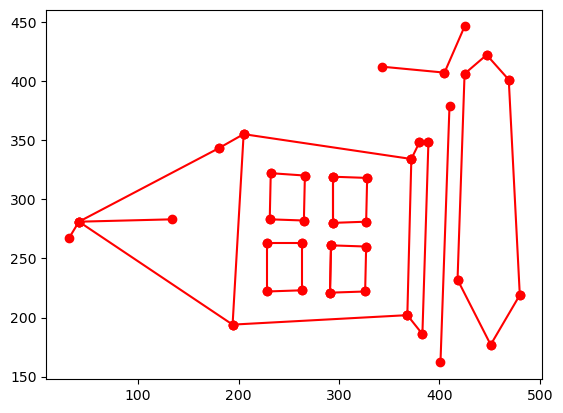

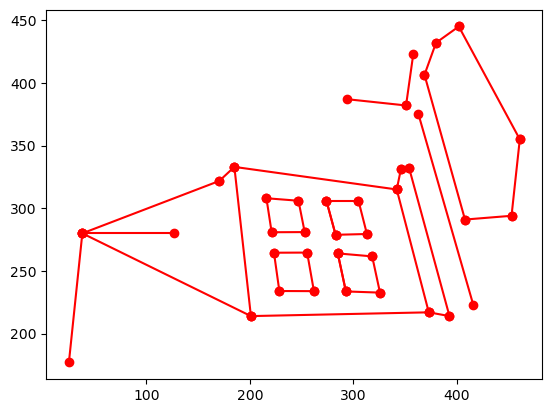

In [43]:
# TODO: Plot edges over image (view) 2 and 5
# Plot edges overlayed on view 2
plot_edges(pts1, edges_processed)

# Plot edges overlayed on view 5
plot_edges(pts2, edges_processed)

**3.a)** Compute the essential matrix E directly from these points using
homogeneous linear least-squares.

In [44]:
# Compute the essenial matrix E using homogeneous linear least-squares
def compute_E(pts1, pts2):
   """
   Params:
   -------
   pts1: np.array
         array of size (N, 2). N points of coordinates (x, y) in view 1.
   pts2: np.array
         array of size (N, 2). N points of coordinates (x, y) in view 2.
   
   Returns:
   --------
   E: np.array
         array of size (3, 3). Essential matrix.
   """

   N = pts1.shape[0]
   A = []
   for i in range(N):
       x1, y1 = pts1[i]
       x2, y2 = pts2[i]
       A.append([x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, 1])
   A = np.array(A)
   
   # Compute SVD of A
   U, S, Vt = np.linalg.svd(A)
   
   # Solve for E: the solution is the last column of V (last row of Vt)
   E_approx = Vt[-1].reshape(3, 3)
   
   # Enforce the rank-2 constraint on E (set smallest singular value to 0)
   Ue, Se, Vte = np.linalg.svd(E_approx)
   Se[2] = 0
   E = Ue @ np.diag(Se) @ Vte
   
   # Return the Essential matrix
   return E

# Compute E using the above function
E = compute_E(pts1, pts2)
print("Estimated E:\n", E)
    

Estimated E:
 [[ 4.08336118e-07  4.54314846e-06 -3.63858420e-03]
 [-3.40594547e-06  4.93768111e-06 -8.20503446e-04]
 [ 2.46956438e-03 -4.13679234e-03  9.99981438e-01]]


**3.b)** Report the mean distance between the points (for example from view 1) and the corresponding epipolar lines.

In [45]:
def compute_mean_distance(pts1, pts2, E):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    E: np.array
        array of size (3, 3). Essential matrix.

    Returns:
    --------
    mean_distance: float
        mean distance between points (view 1) and epipolar lines (view 2)
    """

    distances = []

    for i in range(len(pts1)):
        # Get homogeneous coordinates for the current pair
        x1, y1 = pts1[i]
        x2, y2 = pts2[i]
        pt1_h = np.array([x1, y1, 1.0])
        pt2_h = np.array([x2, y2, 1.0])
        
        # Compute the epipolar line l in the second view (l = E * x)
        l = E @ pt1_h   # l = [a, b, c]
        a, b, c = l
        
        # Compute the distance from pt2 to the line l:
        d = abs(a*x2 + b*y2 + c) / np.sqrt(a*a + b*b)
        distances.append(d)
    
    # Return the mean distance
    return np.mean(distances)

# TODO: Check distances
mean_dist = compute_mean_distance(pts1, pts2, E)
print(f"Mean epipolar distance (view1 points to view2 lines): {mean_dist:.4f}")


Mean epipolar distance (view1 points to view2 lines): 98.8298


**4.a)** Write a function, that given E, draws the epipolar lines associated
with the points from pts1, and overlays them on the points from
pts2, drawn using plot_edges.

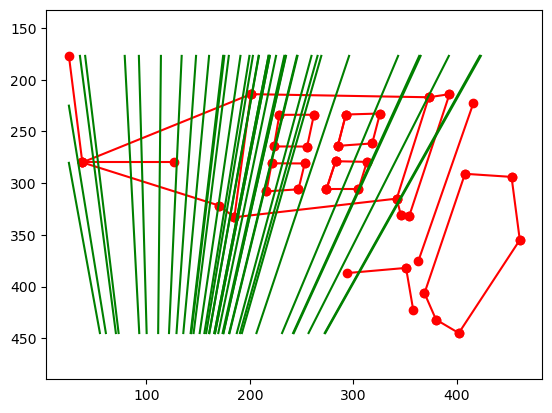

In [46]:
def draw_epipolar_lines(pts1, pts2, E, edges):
    """
    Params:
    -------
    pts1: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 1.
    pts2: np.array
        array of size (N, 2). N points of coordinates (x, y) in view 2.
    E: np.array
        array of size (3, 3). Essential matrix.

    Returns:
    --------
    lines: list
        list of tuples. Each tuple contains the coordinates of the two extremal points of the epipolar segment drawn.
    """
    lines = []
    
    # Plot edges over pts2 (using the given plot_edges without extra arguments)
    plot_edges(pts2, edges)
    
    # Define a bounding box for pts2 to clip the epipolar lines
    x_min = np.min(pts2[:, 0])
    x_max = np.max(pts2[:, 0])
    y_min = np.min(pts2[:, 1])
    y_max = np.max(pts2[:, 1])
    
    # For each point in pts1, compute and draw the corresponding epipolar line in view 2
    for i in range(len(pts1)):
        # Convert point in view1 to homogeneous coordinates
        pt1_h = np.array([pts1[i, 0], pts1[i, 1], 1.0])
        l = E @ pt1_h   # l = [a, b, c] for the line a*x + b*y + c = 0
        a, b, c = l
        
        # Skip degenerate cases
        if abs(a) < 1e-9 and abs(b) < 1e-9:
            continue
        
        pts_line = []
        # Intersection with vertical line at x = x_min
        if abs(b) > 1e-9:
            y_at_xmin = -(c + a*x_min) / b
            if y_min <= y_at_xmin <= y_max:
                pts_line.append((x_min, y_at_xmin))
        # Intersection with vertical line at x = x_max
        if abs(b) > 1e-9:
            y_at_xmax = -(c + a*x_max) / b
            if y_min <= y_at_xmax <= y_max:
                pts_line.append((x_max, y_at_xmax))
        # Intersection with horizontal line at y = y_min
        if abs(a) > 1e-9:
            x_at_ymin = -(c + b*y_min) / a
            if x_min <= x_at_ymin <= x_max:
                pts_line.append((x_at_ymin, y_min))
        # Intersection with horizontal line at y = y_max
        if abs(a) > 1e-9:
            x_at_ymax = -(c + b*y_max) / a
            if x_min <= x_at_ymax <= x_max:
                pts_line.append((x_at_ymax, y_max))
        
        # If at least two intersection points are found, choose the two that are farthest apart
        if len(pts_line) >= 2:
            best_pair = pts_line[:2]
            max_dist = np.linalg.norm(np.array(best_pair[0]) - np.array(best_pair[1]))
            for j in range(len(pts_line)):
                for k in range(j+1, len(pts_line)):
                    d = np.linalg.norm(np.array(pts_line[j]) - np.array(pts_line[k]))
                    if d > max_dist:
                        max_dist = d
                        best_pair = (pts_line[j], pts_line[k])
            # Draw the epipolar line on view 2 (using a different color, e.g., green)
            x_coords = [best_pair[0][0], best_pair[1][0]]
            y_coords = [best_pair[0][1], best_pair[1][1]]
            plt.plot(x_coords, y_coords, 'g-')
            lines.append(best_pair)
    
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()
    
    return lines

# Call the function to draw epipolar lines on view 2
lines_drawn = draw_epipolar_lines(pts1, pts2, E, edges_processed)

**4.b)** Do the same switching the roles of pts1 and pts2.

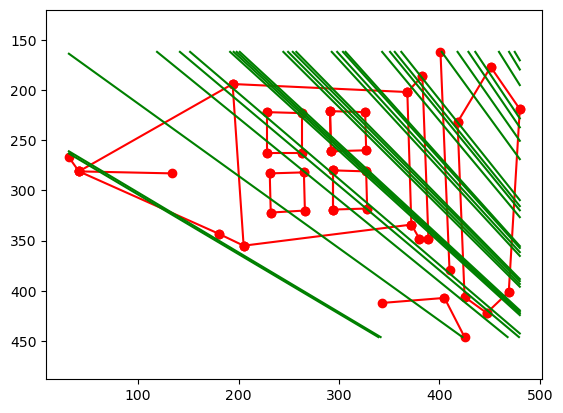

In [47]:
# Here we draw epipolar lines in view 1 corresponding to points from view 2.
def draw_epipolar_lines_switched(pts1, pts2, E, edges):
    """
    Params:
    pts1: (N, 2). N points of coordinates (x, y) in view 1.
    pts2: (N, 2). N points of coordinates (x, y) in view 2.
    E: (3, 3). Essential matrix.
    
    Returns: list of tuples. Each tuple contains the coordinates of the two extremal points 
        of the epipolar segment drawn in view 1.
    """
    lines = []
    
    # Plot edges over pts1 (use the plot_edges function, without extra keyword arguments)
    plot_edges(pts1, edges)
    
    # Define a bounding box for pts1 to clip the epipolar lines
    x_min = np.min(pts1[:, 0])
    x_max = np.max(pts1[:, 0])
    y_min = np.min(pts1[:, 1])
    y_max = np.max(pts1[:, 1])
    
    # For each point in pts2, compute the corresponding epipolar line in view 1.
    # The epipolar line in view 1 is given by l = E^T * x, where x is a point from view2.
    for i in range(len(pts2)):
        # Convert point in view 2 to homogeneous coordinates
        pt2_h = np.array([pts2[i, 0], pts2[i, 1], 1.0])
        # Compute the epipolar line in view 1: l = [a, b, c] such that a*x + b*y + c = 0
        l = E.T @ pt2_h
        a, b, c = l
        
        # Skip degenerate lines
        if abs(a) < 1e-9 and abs(b) < 1e-9:
            continue
        
        pts_line = []
        # Intersection with vertical line at x = x_min
        if abs(b) > 1e-9:
            y_at_xmin = -(c + a * x_min) / b
            if y_min <= y_at_xmin <= y_max:
                pts_line.append((x_min, y_at_xmin))
        # Intersection with vertical line at x = x_max
        if abs(b) > 1e-9:
            y_at_xmax = -(c + a * x_max) / b
            if y_min <= y_at_xmax <= y_max:
                pts_line.append((x_max, y_at_xmax))
        # Intersection with horizontal line at y = y_min
        if abs(a) > 1e-9:
            x_at_ymin = -(c + b * y_min) / a
            if x_min <= x_at_ymin <= x_max:
                pts_line.append((x_at_ymin, y_min))
        # Intersection with horizontal line at y = y_max
        if abs(a) > 1e-9:
            x_at_ymax = -(c + b * y_max) / a
            if x_min <= x_at_ymax <= x_max:
                pts_line.append((x_at_ymax, y_max))
        
        # If we found at least two valid intersection points, select the pair farthest apart.
        if len(pts_line) >= 2:
            best_pair = pts_line[:2]
            max_dist = np.linalg.norm(np.array(best_pair[0]) - np.array(best_pair[1]))
            for j in range(len(pts_line)):
                for k in range(j + 1, len(pts_line)):
                    d = np.linalg.norm(np.array(pts_line[j]) - np.array(pts_line[k]))
                    if d > max_dist:
                        max_dist = d
                        best_pair = (pts_line[j], pts_line[k])
            # Draw the epipolar line (using green for distinction)
            x_coords = [best_pair[0][0], best_pair[1][0]]
            y_coords = [best_pair[0][1], best_pair[1][1]]
            plt.plot(x_coords, y_coords, 'g-')
            lines.append(best_pair)
    
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()
    
    return lines

# Call the function to draw epipolar lines in view 1 (switched roles)
lines_drawn_switched = draw_epipolar_lines_switched(pts1, pts2, E, edges_processed)

**5)** Do the same thing using the Harltley normalization:

**5.a)** Compute the matrices $T_1$ and $T_2$.

In [48]:
# 5.a) Compute the matrices T1 and T2 using Hartley normalization

def compute_normalization_matrix(pts):
    """
    Compute the normalization matrix T for a set of 2D points. The normalization translates the centroid to the origin and scales the 
    points so that their average distance from the origin is sqrt(2).

    Returns: 3x3 normalization matrix.
    """
    # Compute the centroid of the points
    centroid = np.mean(pts, axis=0)
    
    # Compute the average Euclidean distance from the centroid
    dists = np.linalg.norm(pts - centroid, axis=1)
    mean_dist = np.mean(dists)
    
    # Compute the scale factor so that the average distance becomes sqrt(2)
    scale = np.sqrt(2) / mean_dist
    
    # Build the normalization matrix T
    T = np.array([
        [scale,    0, -scale * centroid[0]],
        [   0, scale, -scale * centroid[1]],
        [   0,    0,                    1]
    ])
    return T

# Compute the normalization matrices for each view
T1 = compute_normalization_matrix(pts1)
T2 = compute_normalization_matrix(pts2)

print("T1:\n", T1)
print("T2:\n", T2)

T1:
 [[ 0.01236316  0.         -3.84103967]
 [ 0.          0.01236316 -3.62566035]
 [ 0.          0.          1.        ]]
T2:
 [[ 0.0139543   0.         -4.08066297]
 [ 0.          0.0139543  -4.17290097]
 [ 0.          0.          1.        ]]


**5.b)** Compute the new matrice $E'$

In [49]:
def compute_E_with_hartley(pts1, pts2, T1, T2):
    """
    Computes the new matrix E' using Hartley normalization.
    
    Params:
    pts1 : (N,2) containing the 2D points from view 1.
    pts2 : (N,2) containing the 2D points from view 2.
    T1 : 3x3 normalization matrix for pts1.
    T2 : 3x3 normalization matrix for pts2.
    
    Returns: The denormalized essential matrix computed with Hartley normalization.
    """
    # Convert the points to homogeneous coordinates
    N = pts1.shape[0]
    pts1_h = np.hstack([pts1, np.ones((N, 1))])
    pts2_h = np.hstack([pts2, np.ones((N, 1))])
    
    # Normalize the points using T1 and T2
    pts1_n = (T1 @ pts1_h.T).T
    pts2_n = (T2 @ pts2_h.T).T
    
    # Since compute_E expects Nx2 arrays, extract the first two coordinates
    pts1_n = pts1_n[:, :2]
    pts2_n = pts2_n[:, :2]
    
    # Compute the essential matrix on the normalized points.
    E_norm = compute_E(pts1_n, pts2_n)
    
    # Denormalize using the relation: E' = T2^T * E_norm * T1.
    E_prime = T2.T @ E_norm @ T1
    
    # Enforce the rank-2 constraint once again.
    Ue, Se, Vte = np.linalg.svd(E_prime)
    Se[2] = 0
    E_prime = Ue @ np.diag(Se) @ Vte
    
    return E_prime

# Compute the new E' using the normalization matrices computed in 5.a)
E_prime = compute_E_with_hartley(pts1, pts2, T1, T2)
print("E' computed with Hartley normalization:\n", E_prime)

E' computed with Hartley normalization:
 [[ 4.38960306e-07  3.83213831e-06  8.23519333e-03]
 [ 3.72202580e-06 -4.62047366e-07 -4.51898087e-04]
 [-1.01233677e-02  6.73031293e-04 -1.56172050e-02]]


**5.c)** Report the mean distance between the points and the corresponding epipolar lines.

In [50]:
mean_dist_prime = compute_mean_distance(pts1, pts2, E_prime)
print("Mean epipolar distance (Hartley normalized): {:.4f}".format(mean_dist_prime))


Mean epipolar distance (Hartley normalized): 0.8995


**5.d)** Draw the epipolar lines associated with the points from `pts2` and overlay them on the points from
`pts1`, drawn using `plot_edges`.

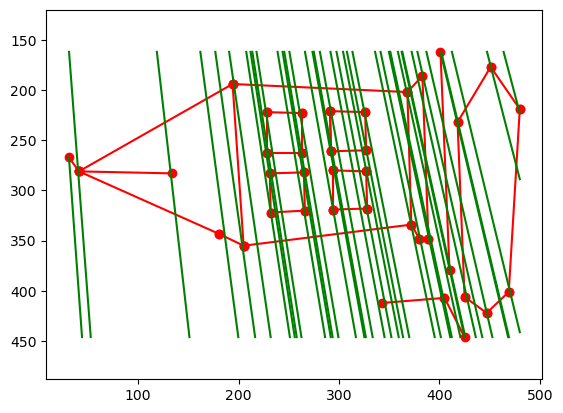

In [51]:
lines_drawn_switched_H = draw_epipolar_lines_switched(pts1, pts2, E_prime, edges_processed)


**5.e)** Do the same switching the roles of `pts1` and `pts2`. Comment on the effect on normalization.

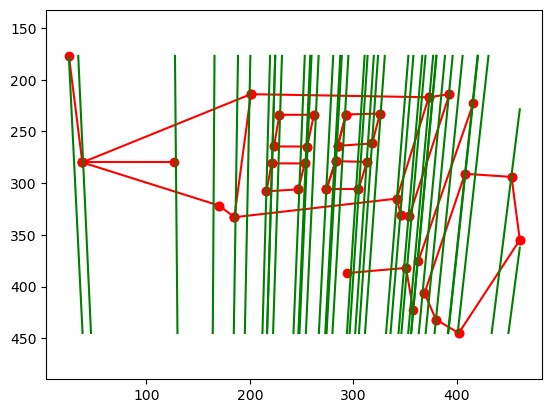

In [52]:
lines_drawn_H_switched = draw_epipolar_lines(pts1, pts2, E_prime, edges_processed)

Before applying Hartley normalization, the essential matrix computed directly from the raw data resulted in a mean epipolar distance of approximately 98.83 (measured from the points in view 1 to their corresponding epipolar lines in view 2). This relatively high value is an indication that the estimation suffers from significant numerical inaccuracies. These inaccuracies stem from the fact that the original point coordinates can have very different scales and offsets, which in turn affect the conditioning of the underlying linear system used to compute the essential (or fundamental) matrix.

After applying Hartley normalization, where both sets of points are translated so that their centroids lie at the origin and scaled so that their average distance from the origin is 2sqrt(2), the mean epipolar distance is reduced dramatically to approximately 0.90. This improvement demonstrates that:

- Normalization Improves Numerical Stability: By scaling the coordinates to a similar range, the resulting system of equations for computing the essential matrix becomes much better conditioned. This results in a more accurate estimation.

- Enhanced Accuracy of Epipolar Geometry: The lower mean distance indicates that the computed epipolar lines are in much better agreement with the corresponding points in the other view. Essentially, the error induced by numerical instability is minimized.

- Symmetry with View Switching: In part 5.e, when the roles of pts1 and pts2 are switched (i.e., drawing epipolar lines in view 2 for points in view 1), the normalized estimation ensures that the geometry is consistent and symmetric. This is a direct benefit of Hartley normalization—by standardizing the points in both views, the computed essential matrix is less affected by any biases that could arise from differences in point distribution between the two views.

